<a href="https://colab.research.google.com/github/Grupo242022/AN_Supervisado_2022/blob/main/Pr%C3%A1ctico_NoSupervisado_fifa2022_G24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.-Inicialización-del-entorno

**Empezamos cargando algunas herramientas para cargar los datos y manipularlos.**

In [2]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

import mglearn

from sklearn.cluster import KMeans
from sklearn.preprocessing  import scale

**Para visualización usaremos principalmente plotly, también seaborn y matplotlib.**

In [4]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns


## 2.- Limpieza y Exploración de la base de datos FIFA 22

**Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa22). [Enlace](https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset)  como 'data.csv'.** 

In [5]:
url='https://github.com/Grupo242022/AN_Supervisado_2022/blob/main/players_22.csv?raw=true'
df=pd.read_csv(url, sep=',')



- Damos una mirada rápida al conjunto de datos:

In [6]:
df = pd.read_csv(url)
df.tail(3)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,...,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
19236,262760,https://sofifa.com/player/262760/nathan-logue/...,N. Logue,Nathan Logue-Cunningham,CM,47,55,100000.0,500.0,21,2000-02-07,178,72,111131.0,Finn Harps,Rep. Ireland Airtricity League,1.0,RES,31.0,NaN,2021-06-18,2021.0,25,Republic of Ireland,NaN,NaN,NaN,Right,3,2,1,Medium/Medium,Lean (170-185),No,175000.0,NaN,NaN,60.0,37.0,45.0,49.0,41.0,52.0,39,32,43,49,37,47,37,...,56,50,34,51,38,45,46,39,36,38,44,48,8,6,7,10,6,NaN,45+2,45+2,45+2,46,46,46,46,46,47+2,47+2,47+2,48+2,47+2,47+2,47+2,48+2,47+2,46+2,46+2,46+2,47+2,47+2,45+2,45+2,45+2,47+2,12+2,https://cdn.sofifa.net/players/262/760/22_120.png,https://cdn.sofifa.net/teams/111131/60.png,https://cdn.sofifa.net/flags/ie.png,NaN,https://cdn.sofifa.net/flags/ie.png
19237,262820,https://sofifa.com/player/262820/luke-rudden/2...,L. Rudden,Luke Rudden,ST,47,60,110000.0,500.0,19,2002-04-23,173,66,111131.0,Finn Harps,Rep. Ireland Airtricity League,1.0,RES,12.0,NaN,2021-06-18,2021.0,25,Republic of Ireland,NaN,NaN,NaN,Right,3,2,1,Medium/Medium,Lean (170-185),No,239000.0,NaN,NaN,68.0,46.0,36.0,48.0,15.0,42.0,29,49,40,38,34,42,36,...,50,40,41,34,14,47,40,49,47,10,14,11,7,10,7,14,15,NaN,47+2,47+2,47+2,47,47,47,47,47,45+2,45+2,45+2,45+2,39+2,39+2,39+2,45+2,33+2,29+2,29+2,29+2,33+2,32+2,26+2,26+2,26+2,32+2,15+2,https://cdn.sofifa.net/players/262/820/22_120.png,https://cdn.sofifa.net/teams/111131/60.png,https://cdn.sofifa.net/flags/ie.png,NaN,https://cdn.sofifa.net/flags/ie.png
19238,264540,https://sofifa.com/player/264540/emanuel-lalch...,E. Lalchhanchhuaha,Emanuel Lalchhanchhuaha,CAM,47,60,110000.0,500.0,19,2002-02-06,167,61,113040.0,NorthEast United FC,Indian Super League,1.0,SUB,13.0,NaN,2021-08-31,2025.0,159,India,NaN,NaN,NaN,Right,3,2,1,Medium/Medium,Lean (170-),No,217000.0,NaN,NaN,68.0,38.0,45.0,48.0,36.0,48.0,39,32,46,50,37,48,38,...,57,40,36,55,42,47,46,35,36,33,31,37,8,13,13,9,14,NaN,45+2,45+2,45+2,47,47,47,47,47,47+2,47+2,47+2,48+2,46+2,46+2,46+2,48+2,45+2,44+2,44+2,44+2,45+2,45+2,41+2,41+2,41+2,45+2,16+2,https://cdn.sofifa.net/players/264/540/22_120.png,https://cdn.sofifa.net/teams/113040/60.png,https://cdn.sofifa.net/flags/in.png,NaN,https://cdn.sofifa.net/flags/in.png


- Determinamos el numero de filas y columnas del conjunto de dato. A su vez tomamos de muestra la columna de posicion de jugador y observamos su contenido... 


In [7]:
print(df.columns)
print(len(df.columns), 'variables') # 110 variables

Index(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age',
       ...
       'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url',
       'club_flag_url', 'nation_logo_url', 'nation_flag_url'],
      dtype='object', length=110)
110 variables


In [8]:
df.player_positions.loc[:10,]

0     RW, ST, CF
1             ST
2         ST, LW
3        LW, CAM
4        CM, CAM
5             GK
6         ST, LW
7             GK
8             GK
9             ST
10       CDM, CM
Name: player_positions, dtype: object

#1 - Análisis exploratorio:

 Basandonos en el codigo de [Unal Koroglu - Kaggle](https://www.kaggle.com/code/nalkrolu/fifa-19-complete-player-dataset-analysis), visualizaremos el comportamiento de la base de datos / tipo de jugadores:

In [9]:
# Tipo de jugador - atributos dentro de la variable posicion de jugador:
DEFENDING = ["CB","LB","LCB","LWB","RB","RCB","RWB"]
MIDFIELD = ["CAM","CDM","CM","LAM","LCM","LDM","LM","RAM","RCM","RDM","RM"]
ATTACKING = ["CF","LF","RF","RS","RW","LW","LS","ST"]
GOALKEEPER = ["GK"]

# almacenando estos en un listado
main = []

for i in df["player_positions"]:
    if set(i.split(',')).intersection(DEFENDING):
        main.append("Defensa")
        
    elif set(i.split(',')).intersection(MIDFIELD):
        main.append("Medio campista")
    elif set(i.split(',')).intersection(ATTACKING):
        main.append("Atacante")
    elif set(i.split(',')).intersection(GOALKEEPER):
        main.append("Arquero")
    else:
        main.append(np.nan)

# Incorporando en el conjunto de datos               
df["Main_Position"] = main

In [10]:
df.loc[:10,['short_name','Main_Position', 'player_positions']]

,short_name,Main_Position,player_positions
0,L. Messi,Atacante,"RW, ST, CF"
1,R. Lewandowski,Atacante,ST
2,Cristiano Ronaldo,Atacante,"ST, LW"
3,Neymar Jr,Atacante,"LW, CAM"
4,K. De Bruyne,Medio campista,"CM, CAM"
5,J. Oblak,Arquero,GK
6,K. Mbappé,Atacante,"ST, LW"
7,M. Neuer,Arquero,GK
8,M. ter Stegen,Arquero,GK
9,H. Kane,Atacante,ST


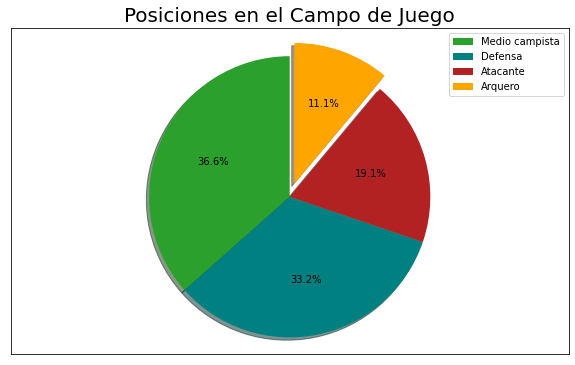

In [11]:
labels  = df["Main_Position"].value_counts().index
sizes   = df["Main_Position"].value_counts().values
explode = (0,0,0,0.1)
plt.figure(figsize=(10,6))
plt.pie(x=sizes,explode=explode,autopct='%1.1f%%',shadow=True, 
        startangle=90, frame=True,colors=["tab:green","teal","firebrick","orange"])
plt.axis('equal')
plt.legend(labels)
plt.title("Posiciones en el Campo de Juego",fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

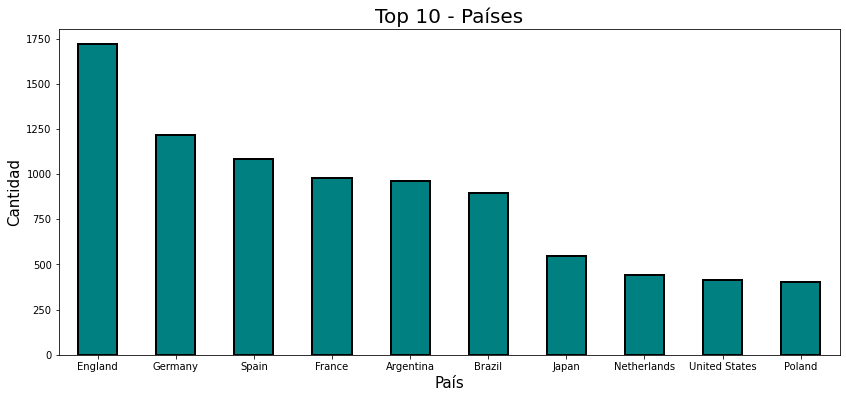

In [12]:
plt.figure(figsize=(14,6))

df["nationality_name"].value_counts()[:10].plot(kind="bar",color="teal",lw=2,edgecolor="black")
plt.xticks(rotation=0)
plt.xlabel("País",fontsize=15)
plt.ylabel("Cantidad",fontsize=15)
plt.title("Top 10 - Países",fontsize=20)
plt.show()

- De la Base de datos la mayoría son medio campistas y el país con mayor presencia de jugadores es Inglaterra.

### Seleccionamos las variables por tipo
    1 - Objeto 
    2- Numericas



In [13]:
# tipo objeto:
s = df.select_dtypes(include = ['object'])
print(len(s.columns), 'variables')
print(f'variables texto: {s.columns}')

51 variables
variables texto: Index(['player_url', 'short_name', 'long_name', 'player_positions', 'dob',
       'club_name', 'league_name', 'club_position', 'club_loaned_from',
       'club_joined', 'nationality_name', 'nation_position', 'preferred_foot',
       'work_rate', 'body_type', 'real_face', 'player_tags', 'player_traits',
       'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
       'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
       'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url',
       'club_flag_url', 'nation_logo_url', 'nation_flag_url', 'Main_Position'],
      dtype='object')


In [14]:
# Tipo numericas - habilidades:
h_num = df.select_dtypes(include = np.number, exclude = float)
print(len(h_num.columns), 'variables')
print(f'variables numericas: {h_num.columns}')


44 variables
variables numericas: Index(['sofifa_id', 'overall', 'potential', 'age', 'height_cm', 'weight_kg',
       'nationality_id', 'weak_foot', 'skill_moves',
       'international_reputation', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',

### Limpieza de la Base de datos para aplicar las técnicas de Clustering:

- Retiramos jugadores con bajo Desempeño global ("Overall") y consideramos Variables de desempeño por habilidad (skills_ratings)

In [15]:
df2= pd.DataFrame()
df2[['short_name','Main_Position']]=s[['short_name','Main_Position']]
skills_ratings = ['overall','skill_moves',
                  'attacking_crossing', 'attacking_finishing',
                  'attacking_heading_accuracy', 'attacking_short_passing',
                  'attacking_volleys', 'skill_dribbling', 'skill_curve',
                  'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
                  'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
                  'movement_reactions', 'movement_balance', 'power_shot_power',
                  'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                  'mentality_aggression', 'mentality_interceptions',
                  'mentality_positioning', 'mentality_vision', 'mentality_penalties',
                  'mentality_composure', 'defending_marking_awareness',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
                  'goalkeeping_positioning', 'goalkeeping_reflexes'
                 ]
df2[skills_ratings]=h_num[skills_ratings]



In [16]:
df2=df2[(df2['overall']>75)].loc[:10000] # los primeros jugadores que superen el overall 75

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 0 to 1463
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   short_name                   1464 non-null   object
 1   Main_Position                1464 non-null   object
 2   overall                      1464 non-null   int64 
 3   skill_moves                  1464 non-null   int64 
 4   attacking_crossing           1464 non-null   int64 
 5   attacking_finishing          1464 non-null   int64 
 6   attacking_heading_accuracy   1464 non-null   int64 
 7   attacking_short_passing      1464 non-null   int64 
 8   attacking_volleys            1464 non-null   int64 
 9   skill_dribbling              1464 non-null   int64 
 10  skill_curve                  1464 non-null   int64 
 11  skill_fk_accuracy            1464 non-null   int64 
 12  skill_long_passing           1464 non-null   int64 
 13  skill_ball_control           1464

## - Las anteriores las analizamos por medio de diagramas de cajas:

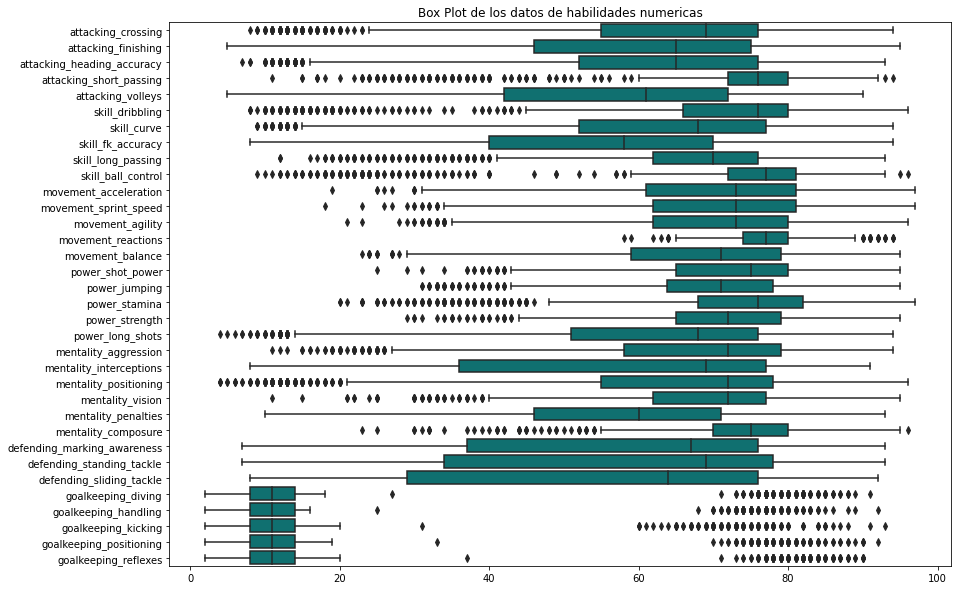

In [18]:
plt.figure(figsize=(14,10))
sns.boxplot(data=df2.iloc[:,4:], orient="h", palette=["teal"])
plt.title("Box Plot de los datos de habilidades numericas")
plt.show()

# 2- Evaluación visual e intuitiva de a dos variables a la vez.

Visualizamos los datos de a dos variables numéricas

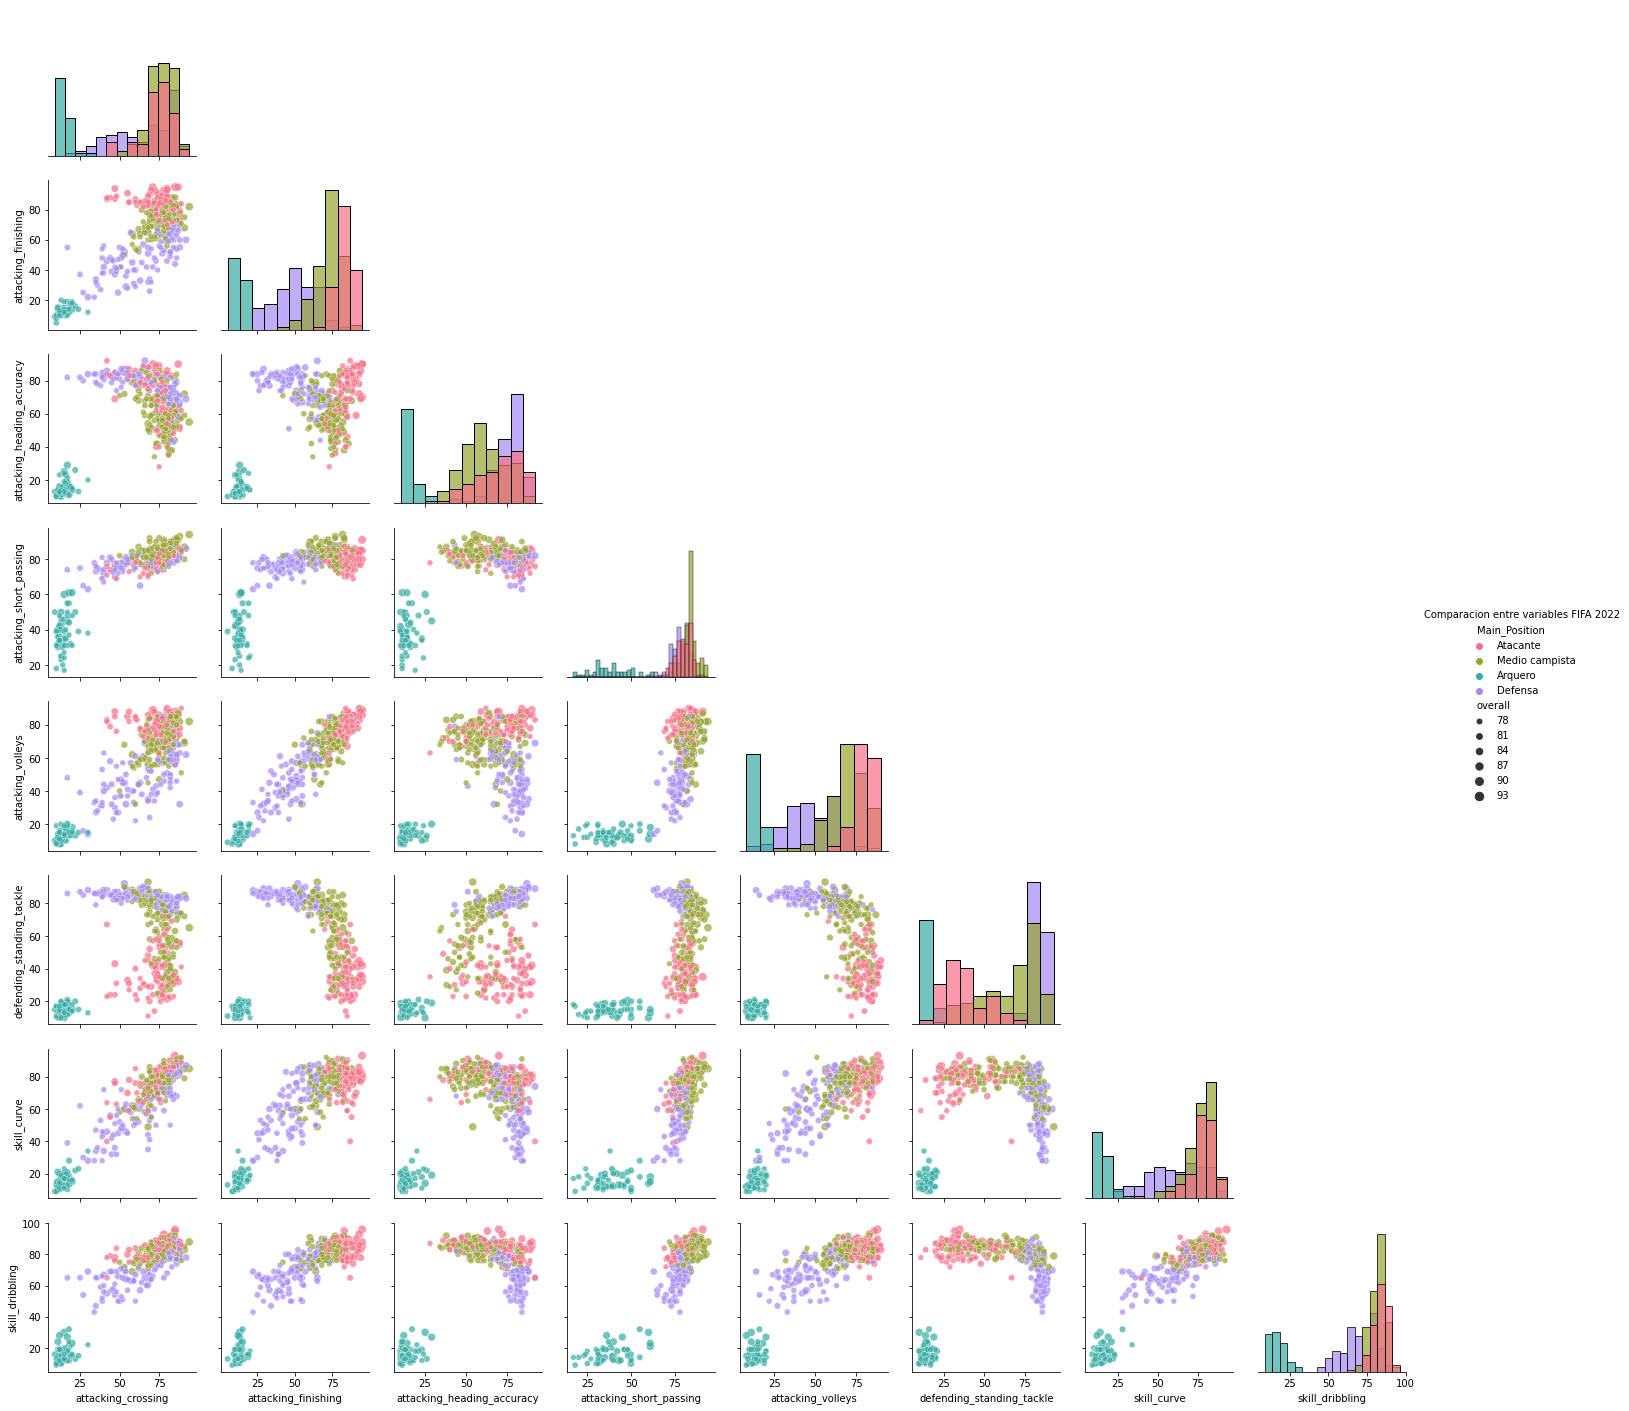

In [39]:
bool_crack=df2["overall"] > 80 # mejores jugadores
exclude=['short_name','overall','skill_moves','skill_fk_accuracy', 'skill_long_passing', 
         'skill_ball_control','movement_acceleration', 'movement_sprint_speed', 'movement_agility',
         'movement_reactions', 'movement_balance', 'power_shot_power','power_jumping', 
         'power_stamina', 'power_strength', 'power_long_shots','mentality_aggression',
         'mentality_interceptions','mentality_positioning', 'mentality_vision', 'mentality_penalties',
         'mentality_composure', 'defending_marking_awareness','goalkeeping_kicking',
         'defending_sliding_tackle','goalkeeping_diving', 'goalkeeping_handling', 
         'goalkeeping_positioning', 'goalkeeping_reflexes']
grids = sns.PairGrid(df2.loc[bool_crack, df2.columns.difference(exclude)],
                     hue='Main_Position', corner=True, palette='husl')
grids.map_diag(sns.histplot, alpha = 0.7)
grids.map_lower(sns.scatterplot, alpha = 0.7, size=df2["overall"])
grids.add_legend(title="Comparacion entre variables FIFA 2022", adjust_subtitles=True)

In [ ]:
bool_crack=df2["overall"] > 80 # mejores jugadores
skill_1= 'defending_standing_tackle'
skill_2= 'skill_curve'

graf1=go.Scatter(x=df2[skill_1], y=df2[skill_2],
                   mode='markers',text=df.loc[:,'Main_Position'], 
                   marker=dict(size=5))

crack=go.Scatter(x=df2.loc[bool_crack,skill_1], y=df2.loc[bool_crack,skill_2],
                 name='Top players',text=df2.loc[bool_crack,'short_name'],
                 textfont=dict(family='sans serif',size=10,color='black'),
                 opacity=0.9,mode='text')
data=[graf1,crack]

layout = go.Layout(title="Visualización de defending_standing_tackle vs skill_curve",
                   titlefont=dict(size=20),xaxis=dict(title=skill_1),yaxis=dict(title=skill_2),
                   autosize=False, width=700,height=700)
fig = go.Figure(data=data, layout=layout)

#En Colab
fig.show(renderer="colab")

# Conclusion:
- En general se puede observar que los arqueros se separan claramente del resto de los jugadores. Esto se puede deber a las habilidades tecnicas requeridas, asi como su comportamiento en la cancha los hace jugadores muy especificos.

# 3- Uso de técnicas de clustering:

## K-Medias:

In [41]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
df_clust= df2.copy()
n_clust = 5

km = KMeans(n_clusters=n_clust)
km.fit(df_clust.select_dtypes(include = np.number, exclude = float).values) #utiliza todas las habilidades: 34 dimensiones

# df2 = df2[df.overall > 86] 
# x = df2.select_dtypes(include = np.number, exclude = float).values # numpy array



# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  3146946.9684437783


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

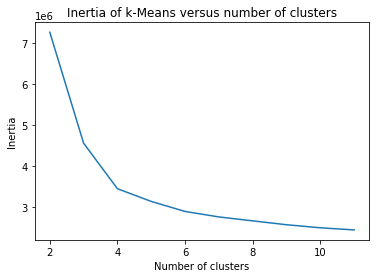

In [43]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_clust.select_dtypes(include=np.number,
                                                          exclude = float).values).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [44]:
bool_crack=df_clust["overall"] > 85
bool_no_crack=df_clust["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[9]
skill_2=skills_ratings[10]

In [45]:
kmean_clusters = go.Scatter(x=df_clust[skill_1], y=df_clust[skill_2],
                           mode='markers',
                        text=df_clust.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_clust.loc[bool_crack,skill_1], y=df_clust.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_clust.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [46]:
#En Colab
fig.show(renderer="colab")

In [47]:
df_clusters=df_clust.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  5 clusters, nosotros forzamos la cantidad


In [ ]:
from sklearn import preprocessing
df2 = df2[df.overall > 86] 
x = df2.select_dtypes(include = np.number, exclude = float).values # numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # 2D PCA for the plot
reduced = pd.DataFrame(pca.fit_transform(X_norm))

In [ ]:
from sklearn.cluster import DBSCAN

# train the model using DBSCAN
db = DBSCAN(eps=1, min_samples=5)

# prediction for dbscan clusters
db_clusters = db.fit_predict(reduced)

In [ ]:
reduced['cluster'] = db_clusters
reduced['name'] = df2.short_name
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head()

,x,y,cluster,name
0,-1.125513,-1.058487,0,L. Messi
1,-0.954358,-0.673106,0,R. Lewandowski
2,-1.036575,-0.971303,0,Cristiano Ronaldo
3,-1.039587,-0.849971,0,Neymar Jr
4,-1.147893,-0.046373,0,K. De Bruyne


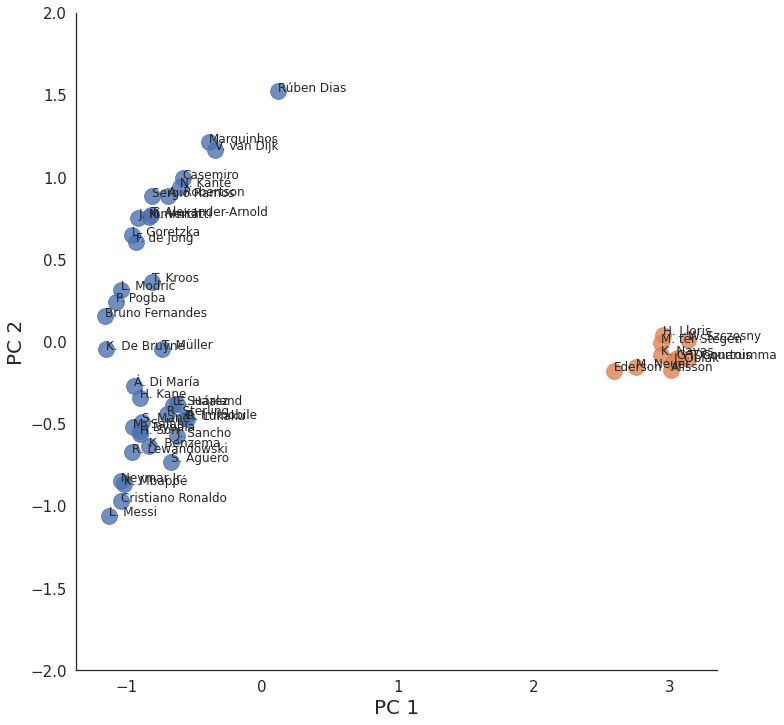

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
                   fit_reg=False, size = 10, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()